<a href="https://colab.research.google.com/github/AshishGusain17/colab_notebooks/blob/main/keras_model_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, multiply, add
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
# from keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB5
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array


from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import model_from_yaml


import numpy as np
import os
import cv2
import datetime
import shutil
import argparse
import random
import pickle
import h5py
import cv2
import math
import time
import gc
import matplotlib
matplotlib.use("Agg")

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')



# GPU_MEMORY_LIMIT = 120

# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(gpu,
#                                                                     [tf.config.experimental.VirtualDeviceConfiguration(
#                                                                         memory_limit=GPU_MEMORY_LIMIT)])
#     except RuntimeError as e:
#         print(e)


In [2]:
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'truncated_normal'
    }
}

filters_se = 128
activation = "swish"

filters = 3072

filters_out = 512

bn_axis = 3

drop_rate = 0.19487179487179487

depth_divisor = 8
width_coefficient = 1.6



# se = layers.Reshape((1, 1, filters), name=name + 'se_reshape')(se)

inp1 = Input(shape = (1, 1, 3072))
inp2 = Input(shape = (None, None, 3072))
inp3 = Input(shape = (None, None, 512))



In [3]:
def round_filters(filters, divisor=depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)
    
    
    
def func(m_name, neuron):
    
    x = Conv2D(
        filters_se,
        1,
        padding='same',
        activation=activation,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_se_reduce' + m_name)(inp1)
    # print(x.get_shape)

    x = Conv2D(
        filters,
        1,
        padding='same',
        activation='sigmoid',
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_se_expand' + m_name)(x)

    x = multiply([inp2, x], name = 'block7c_se_excite' + m_name)

    # Output phase
    x = Conv2D(
        filters_out,
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name = 'block7c_project_conv' + m_name)(x)

    x = BatchNormalization(axis=bn_axis, name = 'block7c_project_bn' + m_name)(x)

    x = Dropout(drop_rate, noise_shape=(None, 1, 1, 1), name = 'block7c_drop' + m_name)(x)

    x = add([x, inp3], name = 'block7c_add' + m_name)





    # Build top
    x = Conv2D(
        round_filters(1280),
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name='top_conv' + m_name)(x)

    x = BatchNormalization(axis=bn_axis, name='top_bn' + m_name)(x)

    x = Activation(activation, name='top_activation' + m_name)(x)

    x = GlobalAveragePooling2D()(x)


    outputs = Dense(neuron, activation = 'sigmoid')(x)

    return outputs
        


In [6]:
output1 = func("_m1", 1)
model1 = Model(inputs = [inp1, inp2, inp3], outputs = output1)
plot_model(model1, to_file='model1.png',show_shapes=True, dpi=40)


output2 = func("_m2", 2)
model2 = Model(inputs = [inp1, inp2, inp3], outputs = output2)
plot_model(model2, to_file='model2.png',show_shapes=True, dpi=40)


output3 = func("_m3", 3)
model3 = Model(inputs = [inp1, inp2, inp3], outputs = output3)
plot_model(model3, to_file='model3.png',show_shapes=True, dpi=40)


output4 = func("_m4", 4)
model4 = Model(inputs = [inp1, inp2, inp3], outputs = output4)
plot_model(model4, to_file='model4.png',show_shapes=True, dpi=40)


output5 = func("_m5", 5)
model5 = Model(inputs = [inp1, inp2, inp3], outputs = output5)
plot_model(model5, to_file='model5.png',show_shapes=True, dpi=40)


output6 = func("_m6", 6)
model6 = Model(inputs = [inp1, inp2, inp3], outputs = output6)
# plot_model(model6, to_file='model6.png',show_shapes=True, dpi=40)

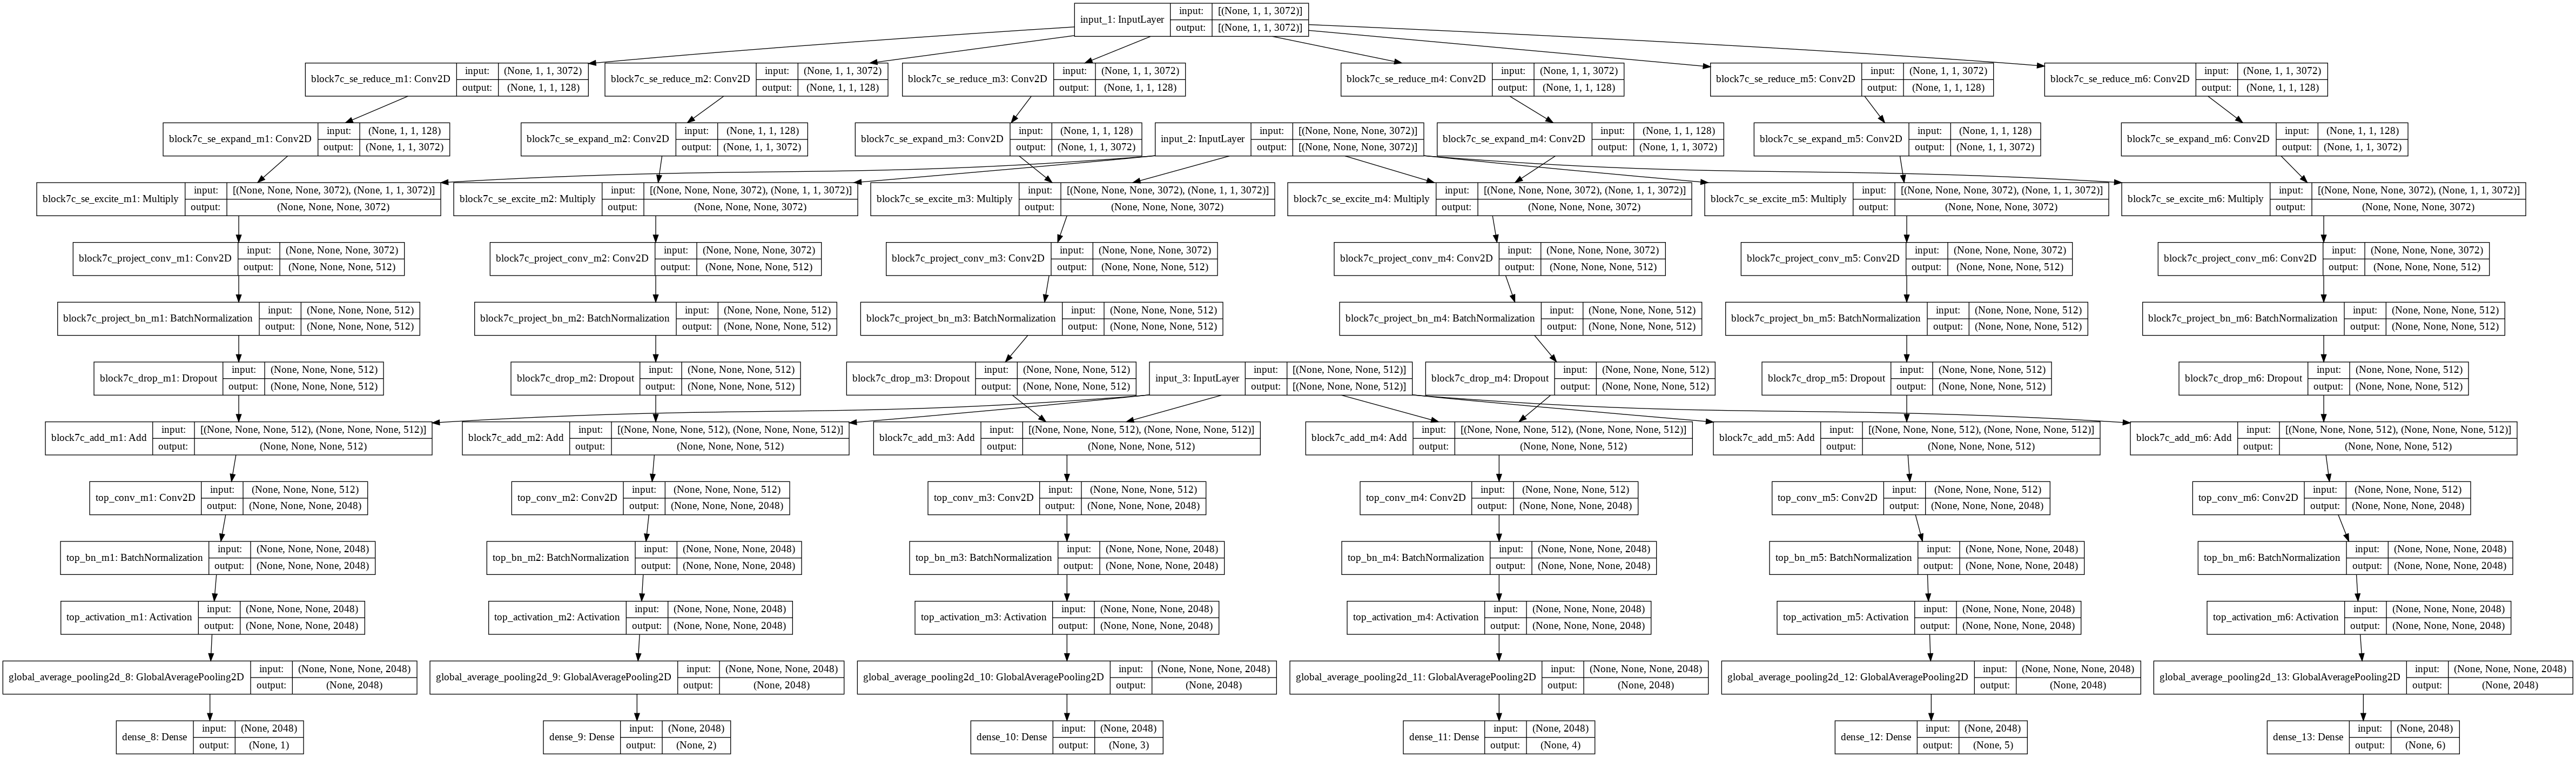

In [7]:
mm = Model(inputs=[inp1, inp2, inp3], outputs=[output1, output2, output3, output4, output5, output6])
plot_model(mm, to_file='mm.png',show_shapes=True)

In [8]:
# inp1 = Input(shape = (1, 1, 3072))
# inp2 = Input(shape = (None, None, 3072))
# inp3 = Input(shape = (None, None, 512))


ans = [np.random.rand(1,1, 1, 3072), np.random.rand(1, 14, 14, 3072), np.random.rand(1, 1, 1, 512)]

In [ ]:
for i in range(20):
    st1 = time.time()

    model1.predict(ans)
    st2 = time.time()

    model2.predict(ans)
    st3 = time.time()

    model3.predict(ans)
    st4 = time.time()

    model4.predict(ans)
    st5 = time.time()

    model5.predict(ans)
    st6 = time.time()

    model6.predict(ans)
    st7 = time.time()

    mm.predict(ans)
    st8 = time.time()

    print((st2-st1)*1000, 
          (st3-st2)*1000, 
          (st4-st3)*1000, 
          (st5-st4)*1000,
          (st6-st5)*1000,
          (st7-st6)*1000,
          (st8-st7)*1000)

In [ ]:
bin_model_15_json = open('bin_model_15_json.json', 'r')
loaded_bin_model_15_json = bin_model_15_json.read()
bin_model_15_json.close()
bin_model_15 = model_from_json(loaded_bin_model_15_json)

# plot_model(bin_model_15, show_shapes=True, dpi=40)

In [ ]:
bin_model_15.name

'functional_5'

In [ ]:
multi_model_15_json = open('multi_model_15_json.json', 'r')
loaded_multi_model_15_json = multi_model_15_json.read()
multi_model_15_json.close()
multi_model_15 = model_from_json(loaded_multi_model_15_json)

plot_model(multi_model_15, show_shapes=True, dpi=40)

In [ ]:
multi_model_15.name

'functional_13'

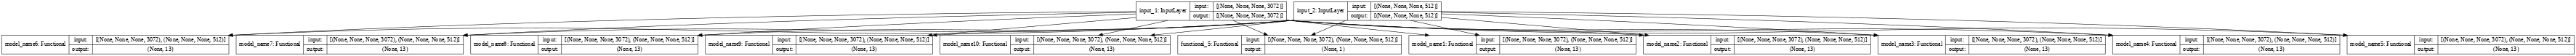

In [ ]:
inp1 = Input(shape = (None, None, 3072))
inp2 = Input(shape = (None, None, 512))

bin1 = bin_model_15([inp1,inp2])

def load_model(num):
    temp_name = "model_name" + str(num)
    model_json = open('multi_model_15_json.json', 'r')
    loaded_model_json = model_json.read()
    model_json.close()
    comp_model = model_from_json(loaded_model_json)
    comp_model._name = temp_name

    
    to_combine = comp_model([inp1, inp2])
    return to_combine

multi1 = load_model(1)
multi2 = load_model(2)
multi3 = load_model(3)
multi4 = load_model(4)
multi5 = load_model(5)
multi6 = load_model(6)
multi7 = load_model(7)
multi8 = load_model(8)
multi9 = load_model(9)
multi10 = load_model(10)
multi11 = load_model(11)


combine_mult_model = Model(inputs=[inp1,inp2], outputs=[bin1, multi1, multi2, multi3, multi4, multi5, multi6,
                                                              multi7, multi8, multi9, multi10])



plot_model(combine_mult_model,show_shapes=True, dpi=40)

In [ ]:
ans = [np.random.rand(1, 14, 14, 3072), np.random.rand(1, 1, 1, 512)]
ans = [np.random.rand(1, 1, 1, 3072), np.random.rand(1, 1, 1, 512)]
import time

for i in range(100):
    st1 = time.time()
    combine_mult_model.predict(ans)

    st2 = time.time()
    multi_model_15.predict(ans)

    st3 = time.time()

    print((st2-st1)*1000, (st3-st2)*1000)


42750.367403030396 227.42319107055664
81.2840461730957 47.06764221191406
105.21769523620605 46.45204544067383
77.28981971740723 46.21577262878418
84.94281768798828 46.36263847351074
76.3556957244873 46.20814323425293
77.0721435546875 51.28312110900879
91.50505065917969 66.65992736816406
116.07170104980469 46.608686447143555
78.42206954956055 48.73919486999512
79.77437973022461 62.69693374633789
76.70092582702637 71.09785079956055
104.59399223327637 70.3895092010498
80.89280128479004 45.62807083129883
106.41908645629883 51.1927604675293
79.85854148864746 51.957130432128906
79.60939407348633 48.2943058013916
78.78541946411133 64.08405303955078
104.7062873840332 62.82758712768555
84.67888832092285 47.20759391784668
77.3172378540039 47.54638671875
78.50933074951172 55.43351173400879
111.4497184753418 45.81475257873535
85.06059646606445 49.82924461364746
76.6294002532959 47.266244888305664
74.85294342041016 46.98467254638672
84.27143096923828 63.521623611450195
85.82758903503418 47.11151123

In [ ]:
multi_model_15.predict(ans)

array([[0.41631028, 0.4235784 , 0.48543018, 0.4355133 , 0.5311233 ,
        0.4689979 , 0.5834867 , 0.6080294 , 0.45834938, 0.52993715,
        0.5142027 , 0.6568688 , 0.5132746 ]], dtype=float32)

In [ ]:
combine_mult_model.predict(ans)


[array([[0.5083588]], dtype=float32),
 array([[0.5060194 , 0.4767246 , 0.45513895, 0.5369515 , 0.51104444,
         0.60076773, 0.60918224, 0.6227106 , 0.56453085, 0.49222085,
         0.49162957, 0.43838224, 0.5051363 ]], dtype=float32),
 array([[0.59224504, 0.4512096 , 0.43271106, 0.45393637, 0.53080636,
         0.5322108 , 0.5609861 , 0.56663483, 0.44155708, 0.57605183,
         0.5941836 , 0.4143572 , 0.4945594 ]], dtype=float32),
 array([[0.40073198, 0.48629004, 0.37835962, 0.43097922, 0.547465  ,
         0.42507625, 0.48288852, 0.40068135, 0.5875241 , 0.5503629 ,
         0.44149286, 0.35449243, 0.4924812 ]], dtype=float32),
 array([[0.5416537 , 0.35621786, 0.3710207 , 0.5507019 , 0.48051855,
         0.6437097 , 0.69055414, 0.48449188, 0.48299953, 0.47076842,
         0.54071426, 0.47411388, 0.5446891 ]], dtype=float32),
 array([[0.45520118, 0.441325  , 0.4651881 , 0.51721543, 0.4854277 ,
         0.46648806, 0.3902    , 0.57562053, 0.60450554, 0.45890948,
         0.5290251 ,